# Reactive covering

## Introduction

EXPLAIN

In [2]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import math
from docplex.mp.model import Model

import random
import json

def showSolution(data,solution):
    
    # print the booking strategy
    print("Bookings:")
    for booking in solution['Bookings']:
        print(booking)

    # show the passes
    minVisiDuration = data['minVisiDuration']
    AOIs = data['AOIs']
    nAOIs = len(AOIs)
    accesses = data['Accesses']
    satPasses = data['Passes']
    nPasses = len(satPasses)
    
    ncols = 3
    nrows = math.ceil(nPasses / ncols)
    proj = ccrs.PlateCarree()
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, subplot_kw={'projection': proj},figsize=(30,80))
    axs = axs.flatten()

    for i in range(nPasses):
        satPass = satPasses[i]
        ax = axs[i]
        ax.set_extent([-15, 25, 35, 60])
        ax.stock_img()
        ax.add_feature(cf.COASTLINE, lw=1)
        ax.add_feature(cf.BORDERS)
        #plt.gcf().set_size_inches(15, 15)    
        for aoi in  AOIs:
            ax.plot([aoi['lon']], [aoi['lat']], 'kx')
        ax.set_title("Pass #{} [{},{}]".format(i,satPass['startDate'],satPass['endDate']))
    
        booking = None
        for bk in solution['Bookings']:
            if bk['passId'] == i:
                booking = bk            
                break
        
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            aoi = AOIs[access['aoiId']]            
            ax.plot([aoi['lon']], [aoi['lat']], 'rx')
            # show the reservations
            if (booking != None) and (booking['bookingStart'] <= access['end'] - minVisiDuration) and (access['start'] + minVisiDuration <= booking['bookingEnd']):
                ax.plot([aoi['lon']], [aoi['lat']], 'bo')

    plt.show()

## Stage 1

Explicar como hemos calculado el coste y como hemos definido la quality y meter un poco de paja rollo intro

In [ ]:
# Import the data
dataFile = open('data/data4.json')  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)
nGoals = len(goals)

# Very basic solver
# We start considering all the AOIs uncovered
covered = [False for i in range(nObsRequests)]
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # Try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not covered[j] and accessId in obsRequest['accessIds']:
                covered[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break

# Computation of the total cost
timeUses = [satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    if (requestStart<=tEnd[passId]-30) and (requestEnd>=tStart[passId]+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# Presentation of the results
print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))

# Export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

In [ ]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)

## Stage 2

EXPLAIN

In [ ]:
# Import the data
dataFile = open('data/data4.json')  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nPasses = len(satPasses)
nGoals = len(goals)

# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables
selectedPass = model.binary_var_list(range(nPasses), name='selectedPass')

# Objectif:
# 1) Minimisation of the cost
model.minimize(model.sum(selectedPass)*data['fixedPassCost']
    + model.sum((satPasses[id]['end'] - satPasses[id]['start'])*selectedPass[id] 
    for id in range(nPasses))*data['passCostPerTimeUnit'])

# Contraints:
# 1) Ensuring that all the goals are covered bu at least one access of a pass
def covering(requestStart, requestEnd, passId, obsReqId):
    if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
        print('Access of the observation request in the pass {0}'.format(passId))
        #if requestStart<=satPasses[passId]['start'] and requestEnd>=satPasses[passId]['end']:
        if requestStart<=(satPasses[passId]['end'] - 30) and requestEnd>=(satPasses[passId]['start'] + 30):
            print('The pass covers the request during its duration')
            return selectedPass[passId]
    return 0

# Checking for all the observation requests
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            print('Observation request ID:{0} for the Aoi {1} and the step {2} goal {3}'.format(obsReqId, aoiId, step, goalId))
            print('Aoi {0}'.format(obsRequests[obsReqId]['aoiId']))
            print('Goal of the observation request:' + str(obsRequests[obsReqId]['goalId']))
            print('Step of the goal:' + str(step) + ' Starting @ ' + str(requestStart) + ' Ending @ ' +  str(requestEnd))
            coverings = [covering(requestStart, requestEnd, passId, obsReqId) for passId in range(nPasses)]
            sum_covering = model.sum(coverings)
            if not str(sum_covering) == "0":
                model.add_constraint(sum_covering >= 1)
            print('----------------------------------------------------------------------')
        aux += goals[goalId]['nSteps']

# Solve:
# Computation time limit
model.set_time_limit(300)

model.print_information()

# Call of the solver
solution = model.solve(log_output=True)

# Getting the solution
selectedPassIds = []
if solution is None:
    raise Exception("No solution")
else:
    for i in range(nPasses):
        if selectedPass[i].solution_value == 1:
            selectedPassIds.append(i)

print('______________________________________________')
# Computation of the total cost
timeUses = [satPasses[id]['end'] - satPasses[id]['start'] for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    if (requestStart<=tEnd[passId]-30) and (requestEnd>=tStart[passId]+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# Presentation of the results
print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))

# Export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()
 

In [ ]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)

## Stage 3

EXPLAIN

In [21]:
# Import the data
dataFile = open('data/data12.json')  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nPasses = len(satPasses)
nGoals = len(goals)

# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables
lbs = []
ubs = []

ube = []
lbe = []

for i in range(nPasses):
    lbs.append(satPasses[i]['start'])
    ubs.append(satPasses[i]['end']-30)
    
    lbe.append(satPasses[i]['start']+30)
    ube.append(satPasses[i]['end'])
    
selectedPass = model.binary_var_list(range(nPasses), name='selectedPass')
#tStart = model.continuous_var_list(range(nPasses), lb=lbs, ub=ubs, name='tStart')
#tEnd = model.continuous_var_list(range(nPasses), lb=lbe, ub=ube, name='tEnd')
tStart = model.continuous_var_list(range(nPasses), lb=lbs, name='tStart')
tEnd = model.continuous_var_list(range(nPasses), ub=ube, name='tEnd')

# Objectif:
# 1) Minimisation of the cost
model.minimize(model.sum(selectedPass)*data['fixedPassCost']
    + model.sum((tEnd[id] - tStart[id])*selectedPass[id] 
    for id in range(nPasses))*data['passCostPerTimeUnit'])

# Contraints:

const = 0
# AQUI FALLA, creo que en los <= y >=
for passId in range(nPasses):
    # 2) tStart constraint
    #model.add_constraint(tStart[passId] >= satPasses[passId]['start'])
    #model.add_constraint(tStart[passId] <= satPasses[passId]['end'])
    # 3) tEnd constraint
    #model.add_constraint(tEnd[passId] <= satPasses[passId]['end'])
    #model.add_constraint(tEnd[passId] >= satPasses[passId]['start'])
    # 4) (tEnd-tStart) >= 30s constraint
    model.add_constraint((tEnd[passId] - tStart[passId]) >= 30)
    
# 1) Ensuring that all the goals are covered bu at least one access of a pass
def accessing(requestStart, requestEnd, passId, obsReqId):
    if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
        #print('Access of the observation request in the pass {0}'.format(passId))
        if requestStart<=(satPasses[passId]['end'] - 30) and requestEnd>=(satPasses[passId]['start'] + 30):
            return selectedPass[passId]
    return 0
# Checking for all the observation requests

for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            if (-requestStart+requestEnd) <= 30:
                print(-requestStart+requestEnd)
            print('Observation request ID:{0} for the Aoi {1} and the step {2} goal {3}'.format(obsReqId, aoiId, step, goalId))
            
            #print('Aoi {0}'.format(obsRequests[obsReqId]['aoiId']))
            #print('Goal of the observation request:' + str(obsRequests[obsReqId]['goalId']))
            #print('Step of the goal:' + str(step) + ' Starting @ ' + str(requestStart) + ' Ending @ ' +  str(requestEnd))
            accessings = [accessing(requestStart, requestEnd, passId, obsReqId) for passId in range(nPasses)]
            sum_accessing = model.sum(accessings)
            if not str(sum_accessing) == "0":
                # 1) Ensuring that all the goals are accessed
                model.add_constraint(sum_accessing >= 1)
                for passId in range(nPasses):
                    if not str(accessings[passId]) == "0":
                        # 2) tStart covering constraint
                        #model.add_constraint(requestStart <= tStart[passId])
                        model.add_constraint(requestStart <= tEnd[passId]-30)
                        # 3) tEnd covering constraint
                        #model.add_constraint(requestEnd >= tEnd[passId])
                        model.add_constraint(requestEnd >= tStart[passId]+30)
                        
            print('----------------------------------------------------------------------')
        aux += goals[goalId]['nSteps']


# Solve
# Time limitation
model.set_time_limit(60)

model.print_information()

# Call of the solver
solution = model.solve(log_output=True)

# solution.display()

# Getting the solution
selectedPassIds = []
if solution is None:
    raise Exception("No solution")
else:
    for i in range(nPasses):
        if selectedPass[i].solution_value == 1:
            selectedPassIds.append(i)
            
print('______________________________________________')
for i in selectedPassIds:
    print(i, tEnd[i].solution_value - tStart[i].solution_value)
print('______________________________________________')

# Computation of the total cost
timeUses = [tEnd[id].solution_value - tStart[id].solution_value for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + model.sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    if (requestStart<=tEnd[passId].solution_value-30) and (requestEnd>=tStart[passId].solution_value+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# Presentation of the results
print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": tStart[i].solution_value, "bookingEnd": tEnd[i].solution_value})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

Observation request ID:0 for the Aoi 0 and the step 0 goal 0
----------------------------------------------------------------------
Observation request ID:1 for the Aoi 1 and the step 0 goal 0
----------------------------------------------------------------------
Observation request ID:2 for the Aoi 2 and the step 0 goal 0
----------------------------------------------------------------------
Observation request ID:3 for the Aoi 3 and the step 0 goal 0
----------------------------------------------------------------------
Observation request ID:4 for the Aoi 4 and the step 0 goal 0
----------------------------------------------------------------------
Observation request ID:5 for the Aoi 5 and the step 0 goal 0
----------------------------------------------------------------------
Observation request ID:6 for the Aoi 6 and the step 0 goal 0
----------------------------------------------------------------------
Observation request ID:7 for the Aoi 7 and the step 0 goal 0
---------------

DOcplexLimitsExceeded: **** Promotional version. Problem size limits (1000 vars, 1000 consts) exceeded, model has 207 vars, 7436 consts, CPLEX code=1016

In [ ]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)

## Stage 4

In [20]:
# Import the data
dataFile = open('data/data12.json')  
data = json.load(dataFile)

# Load data
obsRequests = data['ObservationRequests']
fixedPassCost = data['fixedPassCost']
minVisiDuration = data['minVisiDuration']
aois = data['AOIs']
accesses = data['Accesses']
referenceDate = data['referenceDate']
passCostPerTimeUnit = data['passCostPerTimeUnit']
goals = data['Goals']
satPasses = data['Passes']

# Lengths of lists
nAois = len(aois)
nObsRequests = len(obsRequests)
nPasses = len(satPasses)
nGoals = len(goals)

# OPTIMISATION MODEL
# Model creation
model = Model("reactiveCovering")

# Variables
lbs = []
ubs = []

ube = []
lbe = []

for i in range(nPasses):
    lbs.append(satPasses[i]['start'])
    ubs.append(satPasses[i]['end']-30)
    
    lbe.append(satPasses[i]['start']+30)
    ube.append(satPasses[i]['end'])
    
selectedPass = model.binary_var_list(range(nPasses), name='selectedPass')
#tStart = model.continuous_var_list(range(nPasses), lb=lbs, ub=ubs, name='tStart')
#tEnd = model.continuous_var_list(range(nPasses), lb=lbe, ub=ube, name='tEnd')
tStart = model.continuous_var_list(range(nPasses), lb=lbs, name='tStart')
tEnd = model.continuous_var_list(range(nPasses), ub=ube, name='tEnd')

# Objectif:
# 1) Minimisation of the cost

cost     =  (model.sum(selectedPass)*data['fixedPassCost']
    + model.sum((tEnd[id] - tStart[id])*selectedPass[id] for id in range(nPasses))*data['passCostPerTimeUnit'])

maxcost = 0
for id in range(nPasses):
    maxcost += fixedPassCost + (satPasses[id]['end'] - satPasses[id]['start'])*data['passCostPerTimeUnit'] 


quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for i in range(len(selectedPass)):
                if any(accessIdObsReq in satPasses[i]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                    #if (requestStart<=tEnd[i]-30) and (requestEnd>=tStart[i]+30): 
                    quality += selectedPass[i]
                    break
        aux += goals[goalId]['nSteps']


# for aoiId in range(nAois):
#     aux = 0
#     for goalId in range(nGoals):
#         for step in range(goals[goalId]['nSteps']):
#             obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
#             requestStart = step*goals[goalId]['duStep']
#             requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
#             for passId in selectedPassIds:
#                 if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
#                     if (requestStart<=tEnd[passId]-30) and (requestEnd>=tStart[passId]+30):
#                         quality +=1
#                         break
#         aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

alpha = 0.75
model.minimize(alpha*cost/maxcost+(1-alpha)*(1-quality))

# Contraints:

const = 0
# AQUI FALLA, creo que en los <= y >=
for passId in range(nPasses):
    model.add_constraint((tEnd[passId] - tStart[passId]) >= 30)
    
# # 1) Ensuring that all the goals are covered bu at least one access of a pass
# def accessing(requestStart, requestEnd, passId, obsReqId):
#     if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
#         #print('Access of the observation request in the pass {0}'.format(passId))
#         if requestStart<=(satPasses[passId]['end'] - 30) and requestEnd>=(satPasses[passId]['start'] + 30):
#             return selectedPass[passId]
#     return 0
# # Checking for all the observation requests

# for aoiId in range(nAois):
#     aux = 0
#     for goalId in range(nGoals):
#         for step in range(goals[goalId]['nSteps']):
#             obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
#             requestStart = step*goals[goalId]['duStep']
#             requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
#             if (-requestStart+requestEnd) <= 30:
#                 print(-requestStart+requestEnd)
#             print('Observation request ID:{0} for the Aoi {1} and the step {2} goal {3}'.format(obsReqId, aoiId, step, goalId))

#             accessings = [accessing(requestStart, requestEnd, passId, obsReqId) for passId in range(nPasses)]
#             sum_accessing = model.sum(accessings)
#             if not str(sum_accessing) == "0":
#                 # 1) Ensuring that all the goals are accessed
#                 model.add_constraint(sum_accessing >= 1)
#                 for passId in range(nPasses):
#                     if not str(accessings[passId]) == "0":
#                         # 2) tStart covering constraint
#                         model.add_constraint(requestStart <= tEnd[passId]-30)
#                         # 3) tEnd covering constraint
#                         model.add_constraint(requestEnd >= tStart[passId]+30)
                        
#             print('----------------------------------------------------------------------')
#         aux += goals[goalId]['nSteps']


# Solve
# Time limitation
model.set_time_limit(60)

model.print_information()

# Call of the solver
solution = model.solve(log_output=True)

# solution.display()

# Getting the solution
selectedPassIds = []
if solution is None:
    raise Exception("No solution")
else:
    for i in range(nPasses):
        if selectedPass[i].solution_value == 1:
            selectedPassIds.append(i)
            
print('______________________________________________')
for i in selectedPassIds:
    print(i, tEnd[i].solution_value - tStart[i].solution_value)
print('______________________________________________')

# Computation of the total cost
timeUses = [tEnd[id].solution_value - tStart[id].solution_value for id in selectedPassIds]
totalCost = len(selectedPassIds)*data['fixedPassCost'] + model.sum(timeUses)*data['passCostPerTimeUnit']

# Computation of the quality of the covering: It is defined as the relation of the 
# requests covered over the total amount of requests
quality = 0
for aoiId in range(nAois):
    aux = 0
    for goalId in range(nGoals):
        for step in range(goals[goalId]['nSteps']):
            obsReqId = aoiId + nAois*aux + step + (goals[goalId]['nSteps'] - 1)*aoiId
            requestStart = step*goals[goalId]['duStep']
            requestEnd = step*goals[goalId]['duStep'] + goals[goalId]['rctHorizon']
            for passId in selectedPassIds:
                if any(accessIdObsReq in satPasses[passId]['accessIds'] for accessIdObsReq in obsRequests[obsReqId]['accessIds']):
                     if (requestStart<=tEnd[passId].solution_value-30) and (requestEnd>=tStart[passId].solution_value+30):
                        quality +=1
                        break
        aux += goals[goalId]['nSteps']
        
quality /= nObsRequests

# Presentation of the results
print("IDs of the {0} selected passes: {1}".format(len(selectedPassIds), selectedPassIds))
print("Total cost of the covering: {0}".format(totalCost))
print("Quality of the covering: {0}".format(quality))

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": tStart[i].solution_value, "bookingEnd": tEnd[i].solution_value})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

Model: reactiveCovering
 - number of variables: 207
   - binary=69, integer=0, continuous=138
 - number of constraints: 69
   - linear=69
 - parameters:
     parameters.timelimit = 60.00000000000000
 - objective: minimize quadratic
 - problem type is: MIQP
Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
Found incumbent of value 0.250000 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 28 columns.
MIP Presolve added 164 rows and 82 columns.
Reduced MIP has 233 rows, 261 columns, and 548 nonzeros.
Reduced MIP has 41 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.13 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 228 rows and 256 columns.
Aggregator did 1 substitutions.
Reduced MIP has 4 rows, 4 columns, and 10 nonzeros.
Reduced MIP has 1 binaries, 0 generals, 0 SOSs

Bookings:
{'passId': 0, 'passStart': 0, 'passEnd': 84, 'bookingStart': 0, 'bookingEnd': 30.0}
{'passId': 1, 'passStart': 261, 'passEnd': 593, 'bookingStart': 261.0, 'bookingEnd': 291.0}
{'passId': 2, 'passStart': 1104, 'passEnd': 1449, 'bookingStart': 1104.0, 'bookingEnd': 1134.0}
{'passId': 3, 'passStart': 1624, 'passEnd': 1740, 'bookingStart': 1624.0, 'bookingEnd': 1654.0}
{'passId': 4, 'passStart': 2807, 'passEnd': 3094, 'bookingStart': 2807.0, 'bookingEnd': 2837.0}
{'passId': 5, 'passStart': 3295, 'passEnd': 3437, 'bookingStart': 3295.0, 'bookingEnd': 3325.0}
{'passId': 6, 'passStart': 3748, 'passEnd': 3945, 'bookingStart': 3748.0, 'bookingEnd': 3778.0}
{'passId': 9, 'passStart': 5777, 'passEnd': 6101, 'bookingStart': 5777.0, 'bookingEnd': 5806.999999999997}
{'passId': 14, 'passStart': 9254, 'passEnd': 9464, 'bookingStart': 9254.0, 'bookingEnd': 9283.999999999995}
{'passId': 17, 'passStart': 11293, 'passEnd': 11607, 'bookingStart': 11293.0, 'bookingEnd': 11322.999999999995}
{'passI

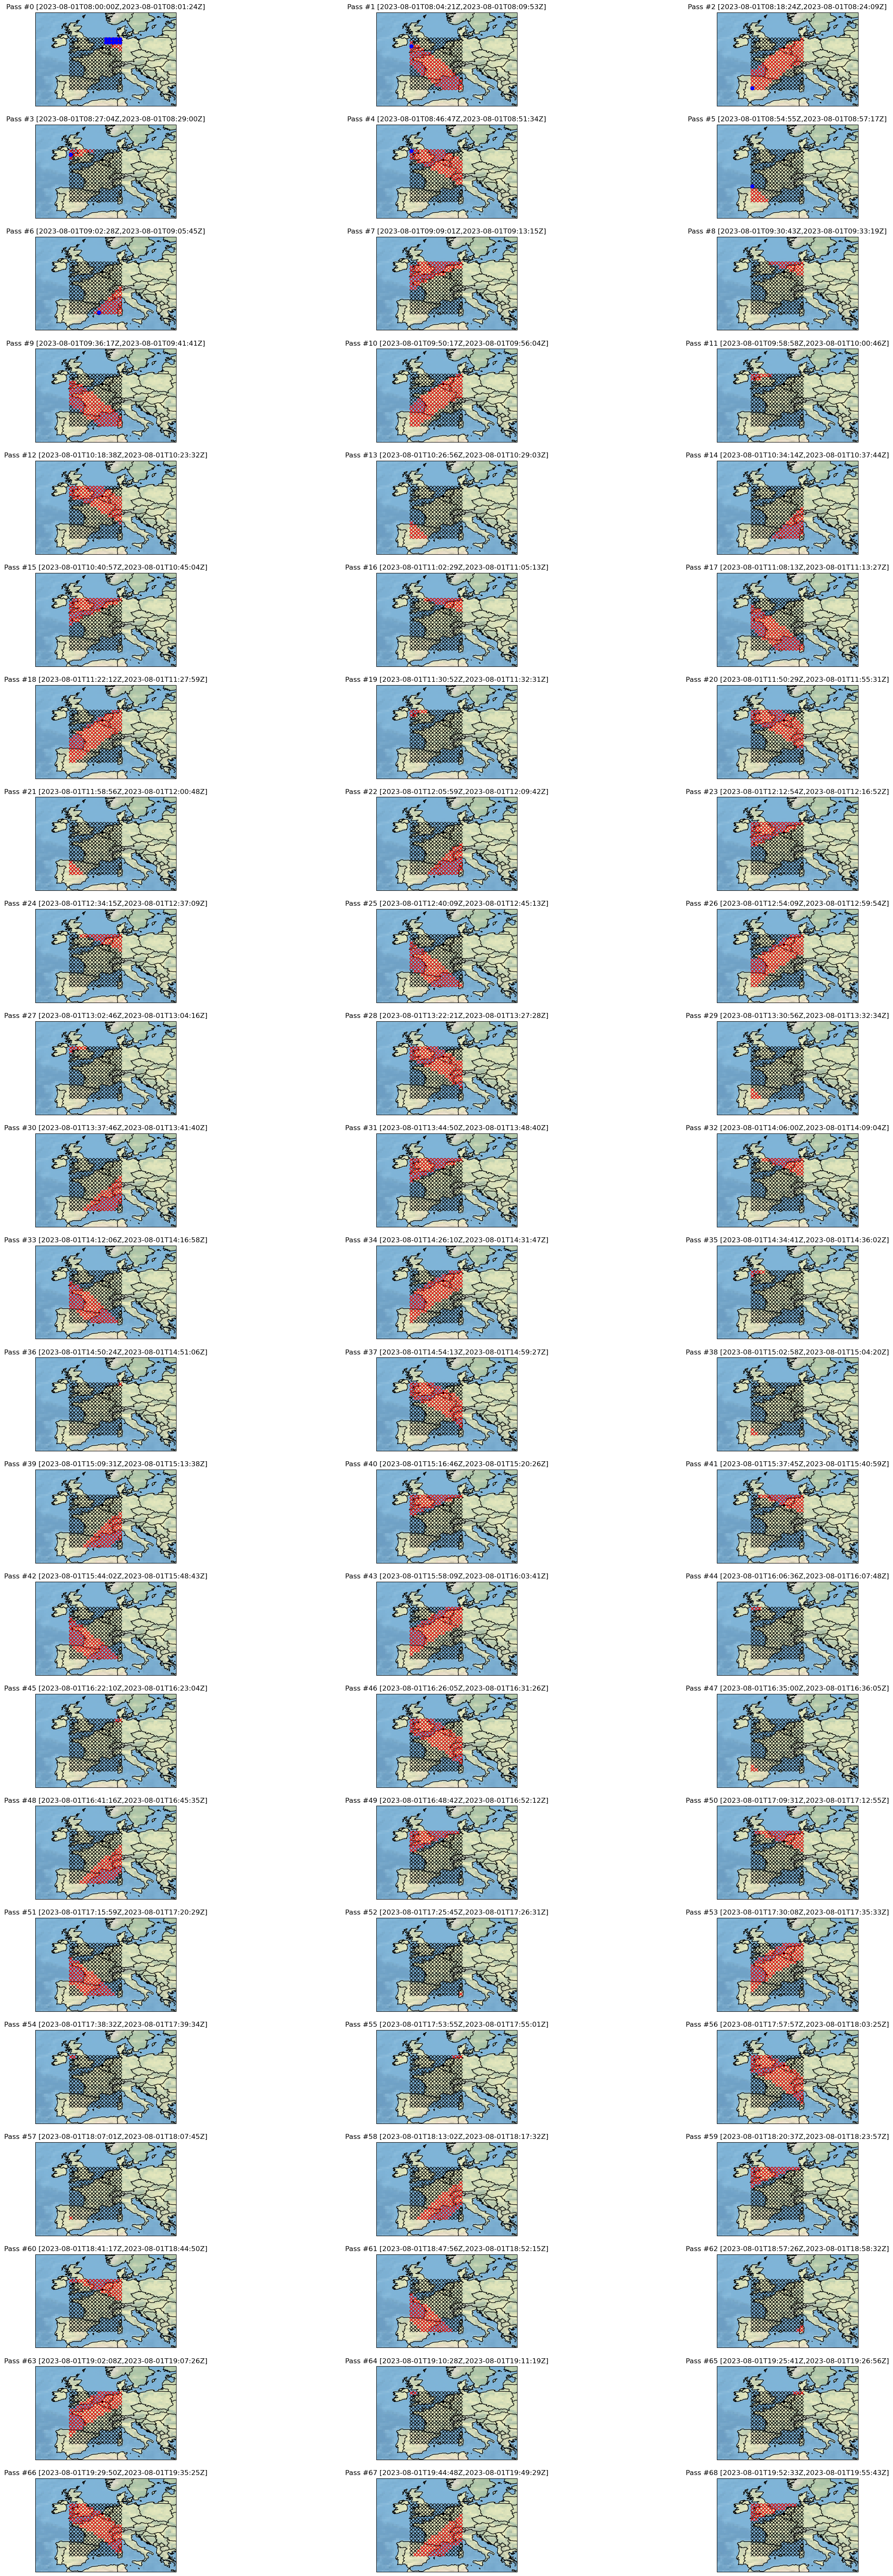

In [12]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)

showSolution(data,solution)